In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import learning_curve, validation_curve

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import backend
import os
from pandas import DataFrame
from numpy import concatenate

import tensorflow as tf
print("Tensorflow:", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, BatchNormalization, Activation, Dropout, LeakyReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import datetime
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, LeaveOneOut, KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
import statistics
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Tensorflow: 2.0.0-alpha0


Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
#************************RPE (Relative Percentage Error)*****************************
def rpe(y_true, y_pred):
    return backend.abs((y_pred - y_true)/y_true * 100)

In [4]:
#*********************** (Root Mean Sequare Error metrics)********************************
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [5]:
#*******************************Load data***************************************
data_raw = []
for week in range(1, 11):
    week_data = pd.read_csv('../Paper1/TUCspam{}.csv'.format(week)).values
    data_raw.append(week_data)

In [6]:
data = np.array(data_raw)
data.shape

(10,)

# sliding window validation

In [7]:
def slidingwindow(n_folds, data):
    data_len = data.shape[0]
    folds = []
    for i in range(1, data_len):
         
        train = [i-1]
        test= [i]
        
        fold_indices = [train, test]
        folds.append(fold_indices)
        
    return folds

In [8]:
data_len = data.shape[0]
for train, test in slidingwindow(data_len, data):
    print('Train: {} \t Test: {}'.format(train, test))
    data_train = data[train]
    data_test = data[test]

Train: [0] 	 Test: [1]
Train: [1] 	 Test: [2]
Train: [2] 	 Test: [3]
Train: [3] 	 Test: [4]
Train: [4] 	 Test: [5]
Train: [5] 	 Test: [6]
Train: [6] 	 Test: [7]
Train: [7] 	 Test: [8]
Train: [8] 	 Test: [9]


In [9]:
for train, test in slidingwindow(data_len, data):
    print('Train: {} \t Test: {}'.format(train, test))
    data_train = data[train]
    data_test = data[test]
    data_train = np.concatenate(data_train)
    data_test = np.concatenate(data_test)
    print(data_train.shape, data_test.shape)

Train: [0] 	 Test: [1]
(428, 1) (669, 1)
Train: [1] 	 Test: [2]
(669, 1) (349, 1)
Train: [2] 	 Test: [3]
(349, 1) (480, 1)
Train: [3] 	 Test: [4]
(480, 1) (341, 1)
Train: [4] 	 Test: [5]
(341, 1) (572, 1)
Train: [5] 	 Test: [6]
(572, 1) (434, 1)
Train: [6] 	 Test: [7]
(434, 1) (511, 1)
Train: [7] 	 Test: [8]
(511, 1) (349, 1)
Train: [8] 	 Test: [9]
(349, 1) (421, 1)


In [10]:
#****************************Create lagged time series dataset*******************
look_back=3

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
data_train= data_train.astype('float32')
data_test = data_test.astype('float32')
    
scaler = MinMaxScaler (feature_range= (-1,1)) 
train_scaled = scaler.fit_transform (data_train)
test_scaled = scaler.transform(data_test)

In [12]:
look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled, look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled, look_back)

In [13]:
train_X = np.reshape(train_X,(train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X,(test_X.shape[0], test_X.shape[1], 1))
print (train_X.shape,train_y.shape, test_X.shape, test_y.shape)

(345, 3, 1) (345,) (417, 3, 1) (417,)


In [14]:
#************************RPE (Relative Percentage Error)*****************************

def rpe(y_true, y_pred):
    return backend.abs((y_pred - y_true)/y_true * 100)

# RNN model

In [15]:
input_shape = train_X[0].shape

def build_network1 ():
    
    #RNN model
    model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_rnn.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
     # fit the model or train on data
    model_rnn.fit (train_X, train_y)
    return model_rnn

# LSTM model

In [16]:
def build_network2 ():
     
    #LSTM model
    model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_lstm.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
    # fit the model or train on data
    model_lstm.fit (train_X, train_y)
    return model_lstm

# GRU model

In [17]:
def build_network3 ():
    
    #GRU model
    model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_gru.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
    # fit the model or train on data
    model_gru.fit (train_X, train_y)
    return model_gru

In [18]:
def get_score(model, train_X, test_X,train_y, test_y):
    model.fit(train_X, train_y)
    return model.score(test_X, test_y)

# Learning curve (training and validation) RNN model

In [19]:
''' Estimator'''
# create model
#model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)

estimator_rnn = KerasRegressor(build_fn=build_network1, batch_size=64, nb_epoch=1, verbose=1)

In [20]:
#estimator_rnn.fit(train_X, train_y)

In [21]:
""" 

'''Cross Validate'''
#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)
#print(cv_scores.mean())

splits = 9
scores = cross_val_score(estimator_rnn, train_X, train_y, cv=splits, scoring= 'neg_mean_squared_error')
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print(scores.mean())

"""

' \n\n\'\'\'Cross Validate\'\'\'\n#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)\n#print(cv_scores.mean())\n\nsplits = 9\nscores = cross_val_score(estimator_rnn, train_X, train_y, cv=splits, scoring= \'neg_mean_squared_error\')\nprint("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))\nprint(scores.mean())\n\n'

In [22]:
# evaluate using 10-fold cross validation

#splits = TimeSeriesSplit(n_splits=9)
#results = cross_val_score(estimator_rnn, train_X, train_y, cv=splits)
#print(results.mean())

In [23]:
splits=9
train_sizes, train_loss, test_loss= learning_curve(
       estimator_rnn, train_X, train_y, cv=splits, scoring='neg_mean_squared_error',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

306/306 [==============================] - 0s 13us/sample


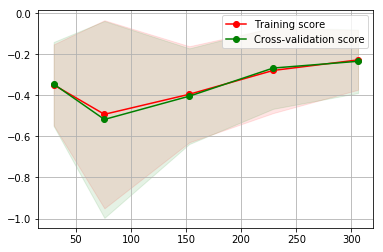

In [24]:
train_loss_mean = np.mean(train_loss, axis=1)
train_loss_std = np.std(train_loss, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
test_loss_std = np.std(test_loss, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")
plt.show()

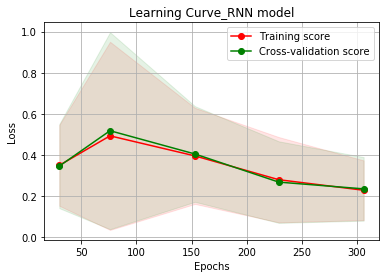

In [25]:
""" train and test loss mean and standard deviation"""

train_loss_mean = -np.mean(train_loss, axis=1)
train_loss_std = -np.std(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)
test_loss_std = -np.std(test_loss, axis=1)
plt.grid()


plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Learning Curve_RNN model')
plt.show()

# Learning curve (training and validation) LSTM model

In [26]:
''' Estimator'''
# create model
#model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)

estimator_lstm = KerasRegressor(build_fn=build_network2, batch_size=64, nb_epoch=1, verbose=1)

In [27]:
""" 
'''Cross Validate'''
#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)
#print(cv_scores.mean())

splits = 9
scores = cross_val_score(estimator_lstm, train_X, train_y, cv=splits, scoring= 'neg_mean_squared_error')
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print(scores.mean())

 """

' \n\'\'\'Cross Validate\'\'\'\n#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)\n#print(cv_scores.mean())\n\nsplits = 9\nscores = cross_val_score(estimator_lstm, train_X, train_y, cv=splits, scoring= \'neg_mean_squared_error\')\nprint("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))\nprint(scores.mean())\n\n '

In [28]:
train_sizes, train_loss, test_loss= learning_curve(
       estimator_lstm, train_X, train_y, cv=splits, scoring='neg_mean_squared_error',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

306/306 [==============================] - 0s 20us/sample


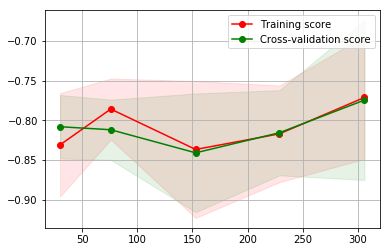

In [29]:
train_loss_mean = np.mean(train_loss, axis=1)
train_loss_std = np.std(train_loss, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
test_loss_std = np.std(test_loss, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")
plt.show()

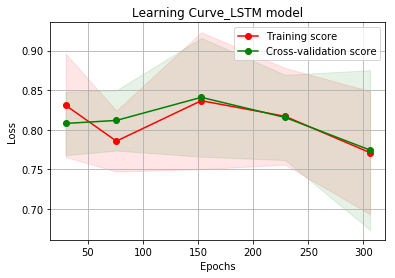

In [30]:
""" train and test loss mean and standard deviation"""

train_loss_mean = -np.mean(train_loss, axis=1)
train_loss_std = -np.std(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)
test_loss_std = -np.std(test_loss, axis=1)
plt.grid()


plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Learning Curve_LSTM model')
plt.show()

# Learning curve (training and validation) GRU model

In [31]:
''' Estimator'''
# create model
#model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)

estimator_gru = KerasRegressor(build_fn=build_network3, batch_size=64, nb_epoch=1, verbose=1)

In [32]:
""" 
'''Cross Validate'''
#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)
#print(cv_scores.mean())

splits = 9
scores = cross_val_score(estimator_gru, train_X, train_y, cv=splits, scoring= 'neg_mean_squared_error')
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print(scores.mean())

 """

' \n\'\'\'Cross Validate\'\'\'\n#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)\n#print(cv_scores.mean())\n\nsplits = 9\nscores = cross_val_score(estimator_gru, train_X, train_y, cv=splits, scoring= \'neg_mean_squared_error\')\nprint("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))\nprint(scores.mean())\n\n '

In [ ]:
train_sizes, train_loss, test_loss= learning_curve(
       estimator_gru, train_X, train_y, cv=splits, scoring='neg_mean_squared_error',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

153/153 [==============================] - 0s 26us/sample


In [ ]:
train_loss_mean = np.mean(train_loss, axis=1)
train_loss_std = np.std(train_loss, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
test_loss_std = np.std(test_loss, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [ ]:
""" train and test loss mean and standard deviation"""

train_loss_mean = -np.mean(train_loss, axis=1)
train_loss_std = -np.std(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)
test_loss_std = -np.std(test_loss, axis=1)
plt.grid()


plt.fill_between(train_sizes, train_loss_mean - train_loss_std,
                     train_loss_mean + train_loss_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_loss_mean - test_loss_std,
                     test_loss_mean + test_loss_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Learning Curve_GRU model')
plt.show()